In [1]:
pip install pandas numpy matplotlib seaborn jupyterlab


Note: you may need to restart the kernel to use updated packages.


In [2]:
#3.1A  Individual Athlete Timeline

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import seaborn as sns


In [17]:
# Load the dataset 
df = pd.read_csv('raw/sixmetrics_data.csv')

In [19]:
# Define the target player names
target_players = ['PLAYER_741', 'PLAYER_555', 'PLAYER_755','PLAYER_995']

# Filter the original DataFrame
selected_players = df[df['playername'].isin(target_players)].copy()

In [22]:
selected_players

,id,playername,timestamp,device,metric,value,team,sportsteam,groupteam
10074,444808,PLAYER_741,2022-06-16 15:59:42,hawkins,Jump Height(M),0.334500,"Group: 2023-2024 WBB, Group: Women's Basketbal...",Basketball,Women's Basketball
10075,444833,PLAYER_741,2022-06-16 15:59:42,hawkins,Peak Propulsive Power(W),3798.655700,"Group: 2023-2024 WBB, Group: Women's Basketbal...",Basketball,Women's Basketball
10076,444838,PLAYER_741,2022-06-16 15:59:42,hawkins,Peak Velocity(M/S),2.673800,"Group: 2023-2024 WBB, Group: Women's Basketbal...",Basketball,Women's Basketball
10077,444866,PLAYER_741,2022-06-16 15:59:42,hawkins,Mrsi,0.401100,"Group: 2023-2024 WBB, Group: Women's Basketbal...",Basketball,Women's Basketball
10078,444887,PLAYER_741,2022-06-16 15:59:55,hawkins,Jump Height(M),0.106400,"Group: 2023-2024 WBB, Group: Women's Basketbal...",Basketball,Women's Basketball
...,...,...,...,...,...,...,...,...,...
100904,6599767,PLAYER_555,2025-10-19 15:25:00,kinexon,Speed_Max,6.096703,Womens Basketball,Basketball,Women's Basketball
101032,6613376,PLAYER_755,2025-10-20 18:31:00,kinexon,Distance_Total,5753.349620,Mens Basketball,Basketball,Men's Basketball
101033,6613437,PLAYER_755,2025-10-20 18:31:00,kinexon,Speed_Max,6.015481,Mens Basketball,Basketball,Men's Basketball
101038,6613622,PLAYER_995,2025-10-20 18:31:00,kinexon,Distance_Total,5125.220385,Mens Basketball,Basketball,Men's Basketball


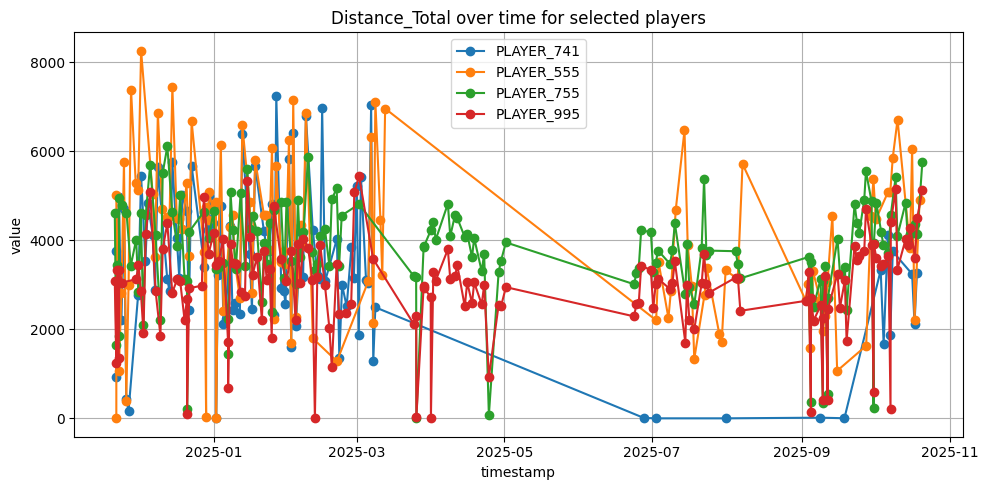

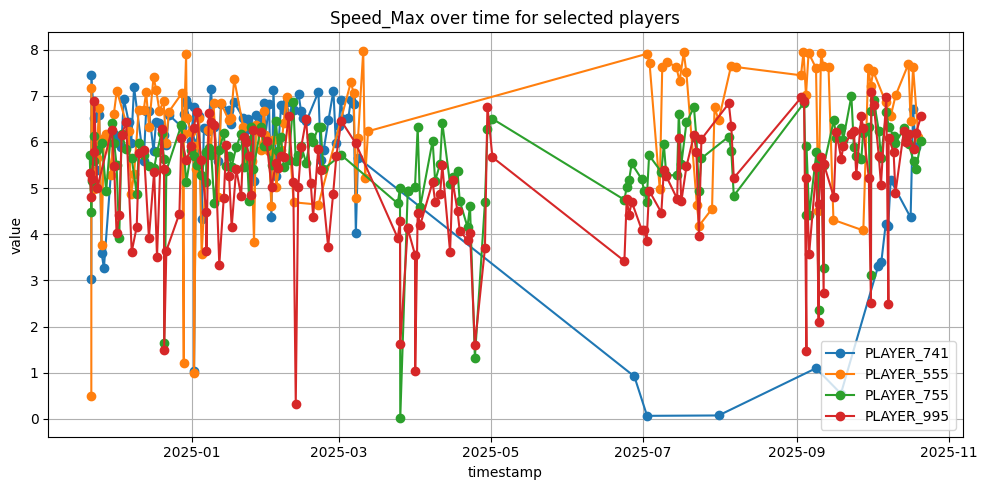

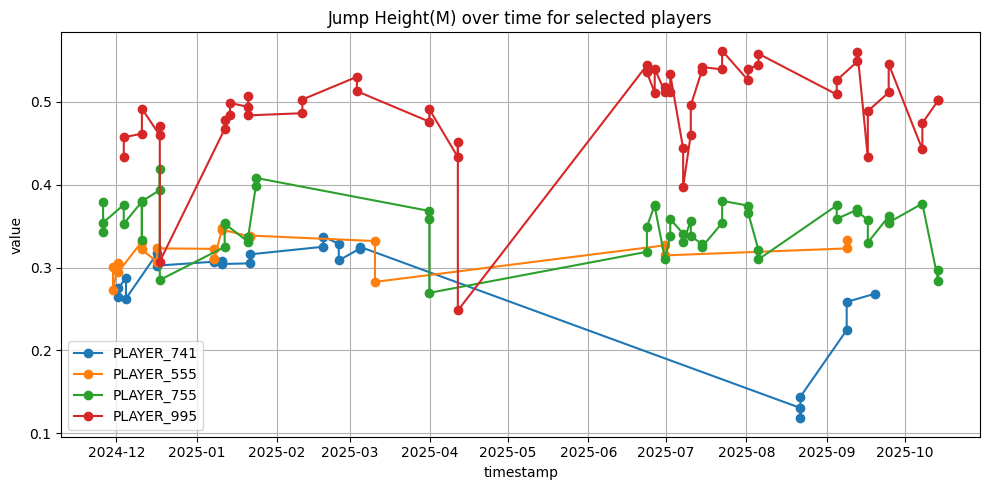

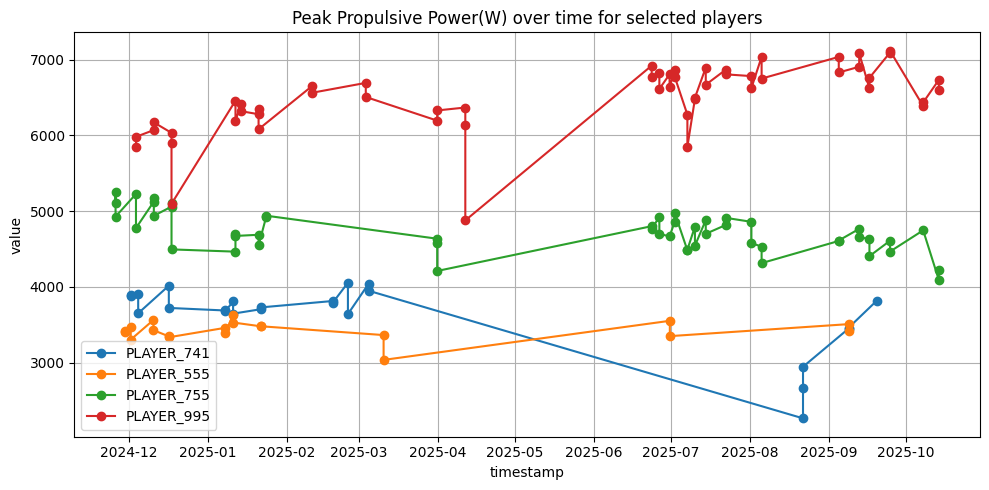

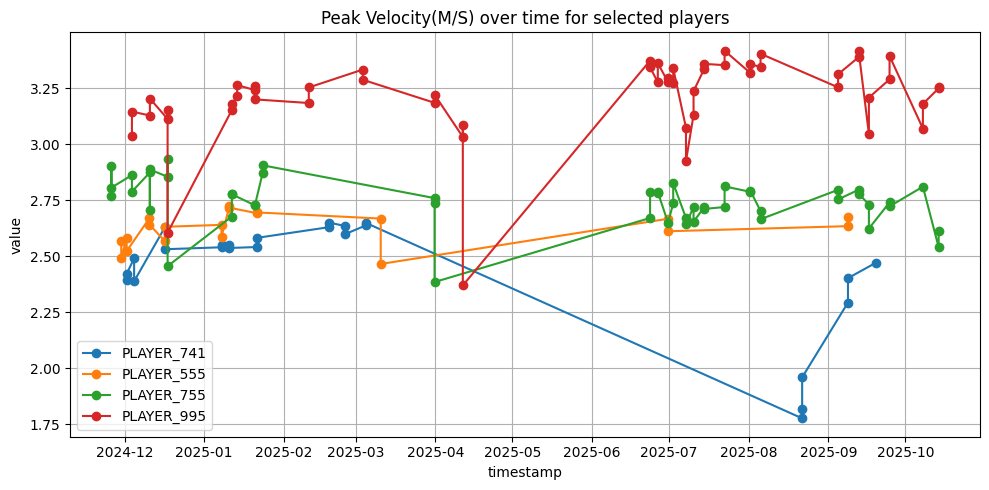

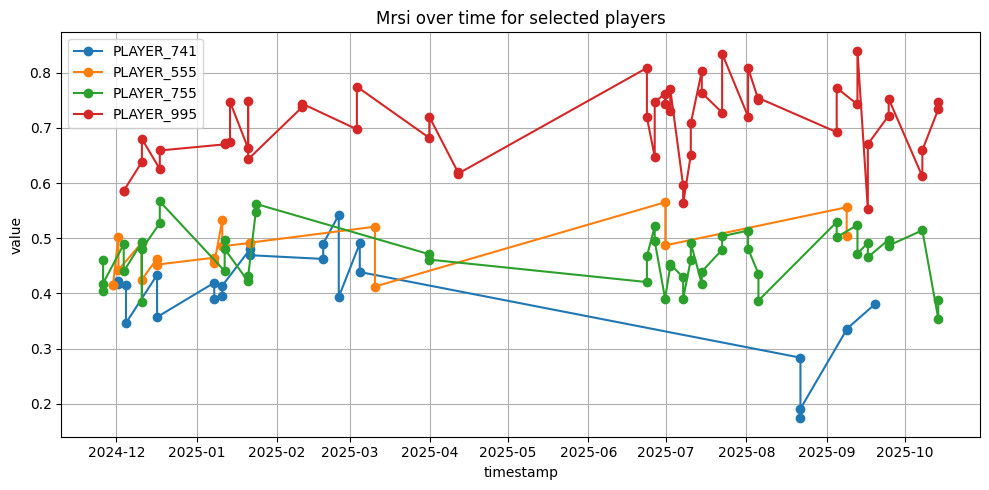

In [23]:
# All 4 players' data visualization
# Convert timestamp to datetime and drop invalid entries
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'], errors='coerce')
selected_players = selected_players.dropna(subset=['timestamp'])

# Filter from current date to 1 year ago
current_date = pd.Timestamp.today()
cutoff_date = current_date - pd.DateOffset(years=1)

# Sort by timestamp to identify oldest records
selected_players = selected_players[selected_players['timestamp'] >= cutoff_date]

# Get unique metrics
metrics = selected_players['metric'].unique()

# Plot each metric across all players
for metric in metrics:
    metric_df = selected_players[selected_players['metric'] == metric]
    plt.figure(figsize=(10, 5))

    # Plot each player's data for this metric
    for player in target_players:
        player_df = metric_df[metric_df['playername'] == player]
        plt.plot(player_df['timestamp'], player_df['value'], marker='o', label=player)

    plt.title(f"{metric} over time for selected players")
    plt.xlabel("timestamp")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

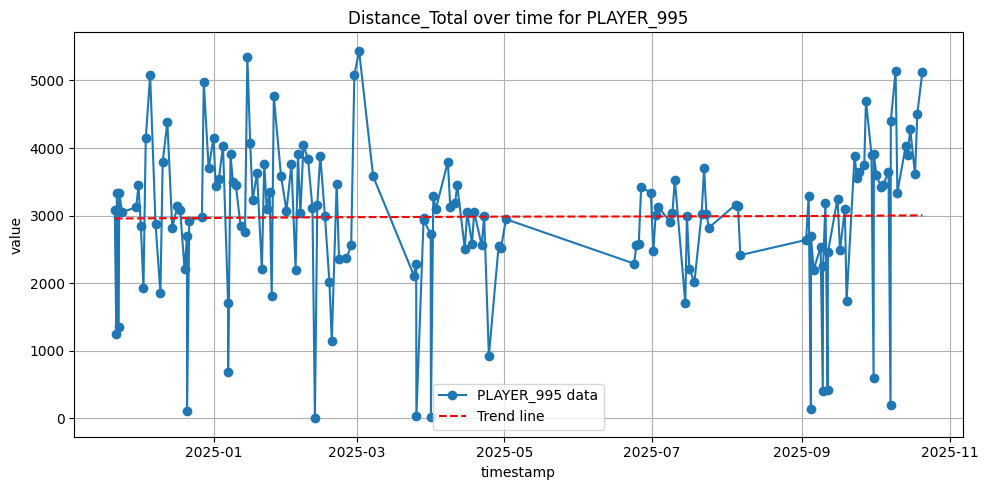

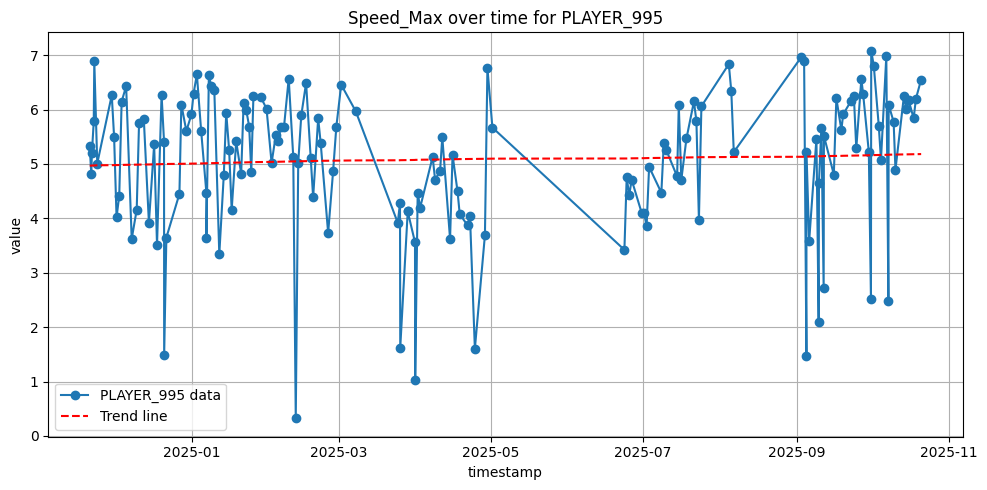

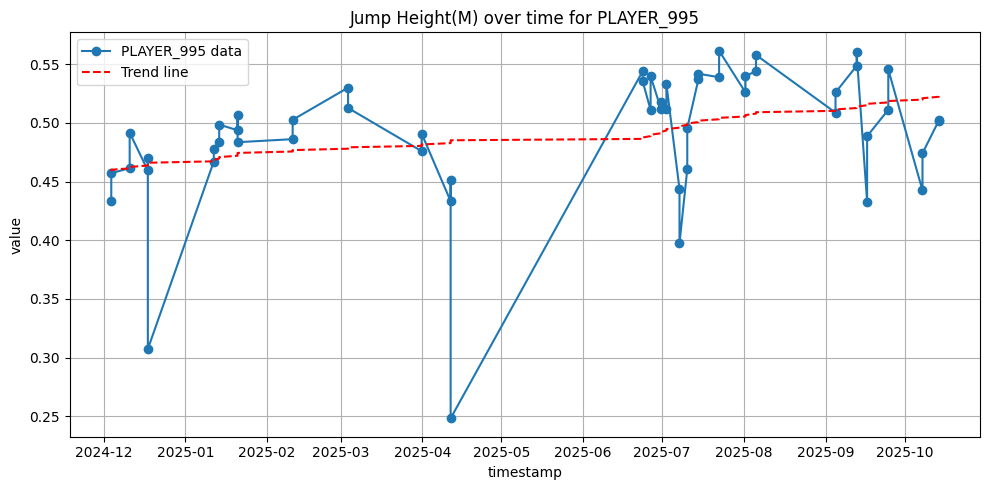

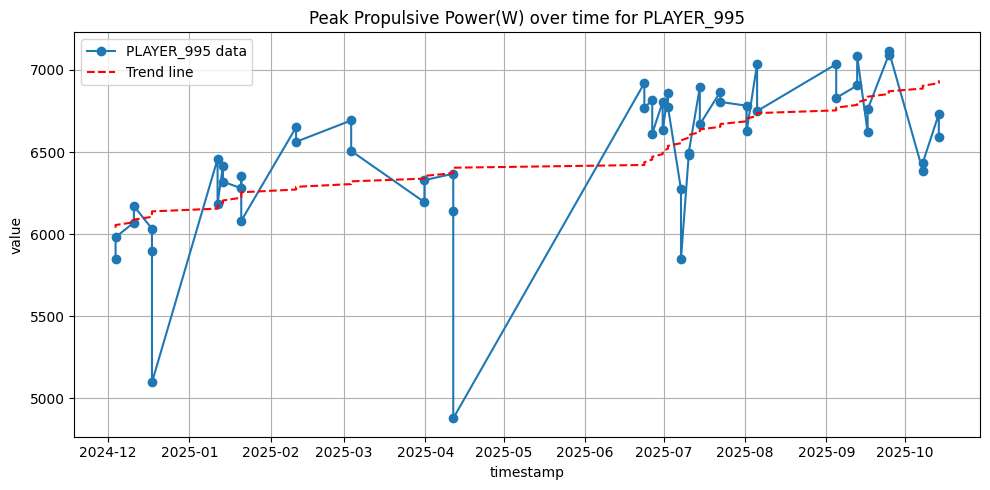

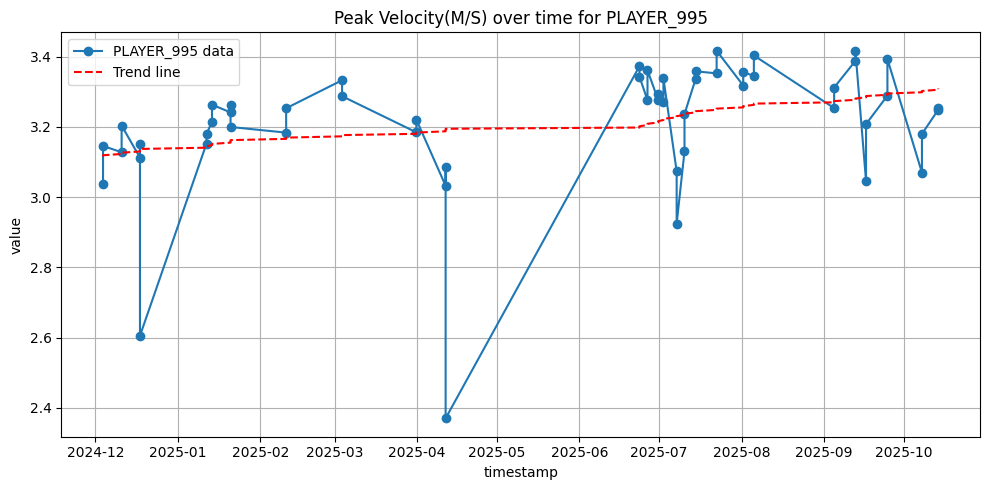

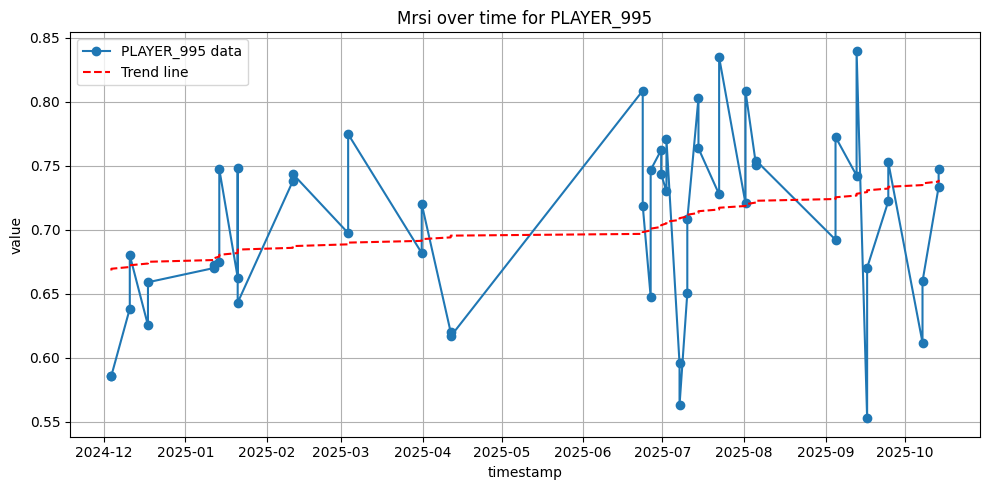

In [31]:
#SINGLE PLAYER VISUALIZATION
# Filter for a single player (e.g., 995)
player_id = 'PLAYER_995'  # Change player ID to choose different players
# Ensure timestamp is datetime
selected_players['timestamp'] = pd.to_datetime(selected_players['timestamp'])

# Filter for chosen player
player_df = selected_players[selected_players['playername'] == player_id]

# Filter for last 12 months
cutoff_date = player_df['timestamp'].max() - pd.DateOffset(months=12)
player_df = player_df[player_df['timestamp'] >= cutoff_date]

# Get unique metrics
metrics = player_df['metric'].unique()

# Plot each metric for the single player
for metric in metrics:
    metric_df = player_df[player_df['metric'] == metric]

    # Prepare x and y
    x = np.arange(len(metric_df['timestamp']))
    y = metric_df['value'].values

    # Fit linear regression (trend line)
    if len(x) > 1:  # only if enough points
        coeffs = np.polyfit(x, y, 1)
        trend = np.poly1d(coeffs)

    plt.figure(figsize=(10, 5))
    plt.plot(metric_df['timestamp'], y, marker='o', label=f"{player_id} data")

    # Add trend line
    if len(x) > 1:
        plt.plot(metric_df['timestamp'], trend(x), color='red', linestyle='--', label="Trend line")

    plt.title(f"{metric} over time for {player_id}")
    plt.xlabel("timestamp")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [11]:
##3.1B Identify their best and worst performance dates
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'value'])

# Group by metric to find best and worst performance dates
best_dates = (
    player_df.loc[player_df.groupby('metric')['value'].idxmax()]
    [['metric', 'value', 'timestamp']]
    .rename(columns={'value': 'best_value', 'timestamp': 'best_date'})
)

worst_dates = (
    player_df.loc[player_df.groupby('metric')['value'].idxmin()]
    [['metric', 'value', 'timestamp']]
    .rename(columns={'value': 'worst_value', 'timestamp': 'worst_date'})
)

# Merge best and worst into one summary
performance_summary = pd.merge(best_dates, worst_dates, on='metric')

# Display results
print(f"Best and worst performance dates for {player_df['playername'].iloc[0]}:")
print(performance_summary.sort_values(by='metric'))

Best and worst performance dates for PLAYER_995:
                     metric   best_value           best_date  worst_value  \
0            Distance_Total  5440.675330 2025-03-01 22:05:36     0.542759   
1            Jump Height(M)     0.561600 2025-07-22 14:28:44     0.248200   
2                      Mrsi     0.839700 2025-09-12 18:52:06     0.552800   
3  Peak Propulsive Power(W)  7117.444600 2025-09-24 19:49:19  4878.451700   
4        Peak Velocity(M/S)     3.416800 2025-07-22 14:28:44     2.369800   
5                 Speed_Max     7.080593 2025-09-30 17:27:01     0.322983   

           worst_date  
0 2025-02-11 15:58:33  
1 2025-04-11 16:45:14  
2 2025-09-16 18:56:01  
3 2025-04-11 16:45:14  
4 2025-04-11 16:45:14  
5 2025-02-11 15:58:33  


In [12]:
#3.1C Calculate if they show improvement or decline trends over the last 12 months for each metric
# Prepare to store trend results
player_name = 'PLAYER_755'  # Change to desired player
player_df = selected_players[selected_players['playername'] == player_name]

# Get unique metrics for this player
metrics_player = player_df['metric'].unique()

# calculate_trend_per_metric
trend_results = []
for metric in metrics_player:
    metric_df = player_df[player_df['metric'] == metric]
    if len(metric_df) >= 2:  #minimum_data_check
        # Convert timestamps to ordinal for regression
        x = metric_df['timestamp'].map(pd.Timestamp.toordinal)
        y = metric_df['value']

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        trend = 'improving' if slope > 0 else 'declining' if slope < 0 else 'stable'

        # Append results
        trend_results.append({
            'metric': metric,
            'slope': slope,
            'trend': trend,
            'p_value': p_value
        })

#display_trend_summary
trend_df = pd.DataFrame(trend_results)
print(f"\nTrend analysis for {player_name} over the last 12 months:")
print(trend_df.sort_values(by='metric'))



Trend analysis for PLAYER_755 over the last 12 months:
                     metric     slope      trend   p_value
0            Distance_Total -0.765999  declining  0.373631
2            Jump Height(M) -0.000058  declining  0.134636
5                      Mrsi -0.000028  declining  0.663735
3  Peak Propulsive Power(W) -1.242051  declining  0.000047
4        Peak Velocity(M/S) -0.000283  declining  0.029561
1                 Speed_Max  0.000555  improving  0.440922
